# CESM2 Large Ensemble 2 Investigation

Daily files are located under `/glade/campaign/cgd/cesm/CESM2-LE/timeseries/atm/proc/tseries/day_1/WSPDSRFAV/*` on the NCAR server.

__Variables analyzed__
- `WSPDSRFAV`: Horizontal total wind speed average at the surface [$m \ s^{-1}$]
- _WSPDSRFAV anomaly_: artificially constructed according to $x_i-\bar{x}_{\text{time}}$

For this study, anomalies are calculated relative to the historical reference period, 1978-2014. Thus $\bar{x}_{\text{time}} = \bar{x}_{1978-2014}$

In [1]:
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
import nc_time_axis
import numpy as np
import pandas as pd
import pwlf
import xarray as xr
import cf_xarray as cfxr   # to use cf_xarray attributes
import metpy.calc as mpcalc  # geostrophic wind
from metpy.units import units
import regionmask
from glob import glob
import scienceplots
import string
import scipy
%matplotlib inline
plt.style.use(["nature", "notebook"])

import matplotlib.animation as animation
from IPython.display import HTML
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 3**128

xr.set_options(keep_attrs=True)
%load_ext rich
from rich import print  # pretty printing
from tqdm import tqdm  # progress bar
import warnings  # deal with warnings

# To access collection
import dask
import intake
# from ncar_jobqueue import NCARCluster
from dask_jobqueue import PBSCluster
from dask.distributed import Client

# Play nice with CMIP6 data
import xclim.ensembles as ensembles

## Helper functions

In [2]:
# Mask using regionmask
def mask_data(data, map, regions: None, drop=False, reverse=False):
    """Mask xarray data based on region names

    Args:
        data (xarray dataset): xarray dataset to mask
        map (regionmask): regionmask object
        regions (list or None): list of region names to mask. if None, all regions are taken. Defaults to None.
        drop (bool, optional): Whether to drop when masking. Defaults to False.
        reverse (bool, optional): Whether to mask the inverse of the regions. Defaults to False.

    Returns:
        xarray dataset: masked dataset
    """
    # Load the region mask
    mask = map.mask(data)
    # Extract keys for the region
    id_dict = map.region_ids
    # Get region names
    if regions is None:
        names = id_dict.keys()
    else:
        # Coerce region names to uppercase
        regions_upper = [region.upper() for region in regions]
        names = [name for name in id_dict.keys() if str(name).upper() in regions_upper]
        assert len(names) == len(regions), 'Not enough regions found'
    # Get the key for the regions
    keys = [id_dict[name] for name in names]
    # Apply the mask to the data
    if reverse:
        masked_data = data.where(~mask.isin(keys), drop=drop)
    else:
        masked_data = data.where(mask.isin(keys), drop=drop)
    return masked_data

# P-value for xarray linear regression
def p_val(r, n,  lat, lon):
    var = np.diag(r.polyfit_covariance.sel(lat=lat, lon=lon))
    #The standard error of the parameter estimates from the variance-covariance matrix is the square root of the diagonal values
    std_err = np.sqrt(var)
    # std_err = std/np.sqrt(n)
    t = r.sel(lat=lat, lon=lon).polyfit_coefficients.values/std_err
    # Degrees of freedom = n-2 (fit two parameters)
    df = n-2
    # Only need to test for slop (degree=1)
    t = t[1]
    return scipy.stats.t.sf(abs(t), df=df)

# Seasonal averages from monthly data
def season_mean(ds, calendar="standard"):
    # Make a DataArray with the number of days in each month, size = len(time)
    month_length = ds.time.dt.days_in_month

    # Calculate the weights by grouping by 'time.season'
    weights = (
        month_length.groupby("time.season") / month_length.groupby("time.season").sum()
    )

    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(weights.groupby("time.season").sum().values, np.ones(4))

    # Calculate the weighted average
    return (ds * weights).groupby("time.season").sum(dim="time").reindex(season =['DJF','MAM','JJA','SON'])

# Yearly averages from monthly data
def mon2yearly(ds, var):
    """
    weight by days in each month
    """
    # Determine the month length
    month_length = ds.time.dt.days_in_month

    # Calculate the weights
    wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()

    # Make sure the weights in each year add up to 1
    np.testing.assert_allclose(wgts.groupby("time.year").sum(xr.ALL_DIMS), 1.0)

    # Subset our dataset for our variable
    obs = ds[var]

    # Setup our masking for nan values
    cond = obs.isnull()
    ones = xr.where(cond, 0.0, 1.0)

    # Calculate the numerator
    obs_sum = (obs * wgts).resample(time="AS").sum(dim="time")

    # Calculate the denominator
    ones_out = (ones * wgts).resample(time="AS").sum(dim="time")

    # Return the weighted average
    return obs_sum / ones_out

# https://stackoverflow.com/questions/48168880/finding-the-center-of-a-contour
def center_of_mass(X):
    # calculate center of mass of a closed polygon
    x = X[:,0]
    y = X[:,1]
    g = (x[:-1]*y[1:] - x[1:]*y[:-1])
    A = 0.5*g.sum()
    cx = ((x[:-1] + x[1:])*g).sum()
    cy = ((y[:-1] + y[1:])*g).sum()
    return 1./(6*A)*np.array([cx,cy])

# List of all East coast states
east_states = [
    'maine',
    'new hampshire',
    'vermont',
    'massachusetts',
    'rhode island',
    'connecticut',
    'new york',
    'delaware',
    'maryland',
    'new jersey',
    'pennsylvania',
    'west virginia',
    'virginia',
    'north carolina',
    'south carolina',
    'georgia',
    'florida',
]

# Regions to mask
us_states = regionmask.defined_regions.natural_earth_v5_0_0.us_states_50
land_region = regionmask.defined_regions.natural_earth_v5_0_0.land_110  # Land has value 0
countries = regionmask.defined_regions.natural_earth_v5_0_0.countries_110

## Spin up Dask cluster

In [3]:
# Create our NCAR Cluster - which uses PBSCluster under the hood
num_jobs = 15

cluster = PBSCluster(
    job_name='valencig_dask',
    cores=1,  # Total number of cores per job
    memory='25GB', # Total amount of memory per job
    processes=1, # Number of Python processes per job
    interface='hsn0', # Network interface to use like eth0 or ib0
    queue='main',
    walltime='02:00:00',
    # resource-spec: select=1:ncpus=128:mem=235GB
    local_directory = '/glade/u/home/valencig/spilled/',
    log_directory = '/glade/u/home/valencig/worker-logs/',
)

# cluster = PBSCluster(
#     job_name = 'valencig-dask-hpc',
#     cores = 1,
#     memory = '10GiB',
#     local_directory = '/glade/u/home/valencig/spilled/',
#     log_directory = '/glade/u/home/valencig/worker-logs/',
#     queue = 'derecho',
#     walltime = '02:00:00', # Change wall time if needed
#     interface = 'ext',
#     account='UNDC0001'
# )

# cluster = NCARCluster(processes=1)

# Spin up workers
cluster.scale(num_jobs)

# Assign the cluster to our Client
client = Client(cluster)

# Change your url to the dask dashboard so you can see it
# dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/${USER}/proxy/${port}/status'})

# Block progress until workers have spawned
client.wait_for_workers(num_jobs)
client

<Client: 'tcp://10.14.1.136:44929' processes=14 threads=14, memory=325.92 GiB>

## Create ensemble

### Get simulation names

- `smbb`: smoothed biomass burning (more info [here](https://www.cesm.ucar.edu/community-projects/lens2))
- `cmip6`: classic CMIP6 forcings

In [ ]:
# Get list of all files
all_files = glob('/glade/campaign/cgd/cesm/CESM2-LE/timeseries/atm/proc/tseries/day_1/WSPDSRFAV/*')
# Simulation runs
simulation_names = set([f.split('.')[2] for f in all_files])
simulation_names

### Load simulations

In [ ]:
# Create dict to store all variants
simulations = dict()

for sim in simulation_names:
    # Extract all member numbers
    sim_files = [f for f in all_files if f.split('.')[2] == sim]
    members = list(set([f.split('.')[4] for f in sim_files]))
    # Create list to store datasets for each member
    sim_list = []
    for member in tqdm(members, desc=f"{sim} - Loading members..."):
        # Get files for this member
        m_files = [f for f in sim_files if f.split('.')[4] == member]
        # Load dataset
        ds = xr.open_mfdataset(m_files, parallel=True)
        # Remove 2100 or 2015 for historical data (data extends to 2099)
        if 'HIST' in sim:
            sliced = ds.sel(time=slice('1978', '2014')).compute()
        elif 'SSP370' in sim:
            sliced = ds.sel(time=slice(None, '2099')).compute()
        # Expand dimension name
        sim_list.append(sliced.WSPDSRFAV)
    simulation = ensembles.create_ensemble(sim_list, realizations=members)
    yearly = simulation.groupby('time.year').mean()  # No need to store daily data
    # Add to dict
    simulations[sim] = yearly.persist().compute()  # This step is slow but speeds up later computation

## Combine simulations by forcing variant

Determine anomaly relative to 1978-2014 mean windspeeds

In [ ]:
cmip6_raw = xr.combine_by_coords([
    simulations['BHISTcmip6'].sortby('realization'),
    simulations['BSSP370cmip6'].sortby('realization')
])
smbb_raw = xr.combine_by_coords([
    simulations['BHISTsmbb'].sortby('realization'),
    simulations['BSSP370smbb'].sortby('realization')
])
forcings = dict(
    cmip6=cmip6_raw - cmip6_raw.sel(year=slice(1978, 2014)).mean('year'),
    smbb=smbb_raw - smbb_raw.sel(year=slice(1978, 2014)).mean('year'),
)

## Global

### Time series

In [ ]:
years = np.arange(1978, 2100)  # 1978-2099


# Dict to store timeseries values
forcing_ts = dict()

# Make plot
fig, axes = plt.subplots(figsize=(14, 5), nrows=1, ncols=2, sharey=True, sharex=True, layout="constrained")

for i, force in enumerate(forcings.keys()):
    ax = axes[i]
    # mask to land
    land = mask_data(forcings[force], land_region, ['land'], drop=True)
    # Eliminate the planet of Hoth
    land = mask_data(land, countries, ['greenland'], reverse=True, drop=True)
    land = land.where((land['lat']>-59).compute(), drop=True)  # antarctica
    land = land.where((land['lat']<70).compute(), drop=True)  # Northern canada
    # Get timeseries
    land_ts = land.mean(['lat', 'lon'])
    # Reduce the simulation
    en_stats = ensembles.ensemble_mean_std_max_min(land_ts)['WSPDSRFAV_mean']
    rolled = en_stats.rolling(year=5, min_periods=1, center=True).mean()
    # Percentiles
    per = ensembles.ensemble_percentiles(land_ts, values=[25, 75], split=True)
    # errs = np.array([per['WSPDSRFAV_p25'], per['WSPDSRFAV_p75']])
    # Plot past
    ax.plot(years[years <= 2014], en_stats[years <= 2014], label='Historical')
    # Plot future (include 2014 so plot connects)
    ax.plot(years[years >= 2014], en_stats[years >= 2014], linewidth=2, label='Projected')
    # Other stats
    ax.plot(years, rolled, label='5-yr rolling mean')
    ax.fill_between(years, per['WSPDSRFAV_p25'], per['WSPDSRFAV_p75'], color='k', alpha=0.2)
    # Plot 1 - Options
    ax.set_title(f'CESM2LENS2 {force.upper()} Forcing')
    
# Options for both plots
for n, ax in enumerate(axes):
    ax.legend(fontsize=10)
    ax.grid(True)
    ax.set_xlabel('Year')
    ax.set_ylabel('NSWS Anomaly [m s$^{-1}$]')
    # ax.vlines(2010, -0.1, 0.1, color='k', linestyle='--')
    ax.set_xlim(years[0], years[-1])
    ax.set_ylim(-0.1, 0.06)
    # Add subplot label
    ax.text(-0.05, 1.05, f'({string.ascii_lowercase[n]})', transform=ax.transAxes, size=20)
fig.suptitle('Global Terrestrial NSWS', fontsize=20)

# Save figure
plt.savefig('figures/cesm2lens2_time_series_global.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

### Spatial plot

In [ ]:
fig = plt.figure(figsize=(12, 8), constrained_layout=True)
gs = fig.add_gridspec(3, 2, width_ratios=[1, 1])  # left plot spatial, right plot signifigance
n = 0  # for subplot labels
for i, force in enumerate(forcings.keys()):
    # mask to land
    land = mask_data(forcings[force], land_region, ['land'], drop=True)
    # Eliminate the planet of Hoth
    land = mask_data(land, countries, ['greenland'], reverse=True, drop=True)
    land = land.where((land['lat']>-59).compute(), drop=True)  # antarctica
    land = land.where((land['lat']<70).compute(), drop=True)  # Northern canada
    # Create axes for plotting
    h = fig.add_subplot(gs[0, i], projection=ccrs.PlateCarree())
    f = fig.add_subplot(gs[1, i], projection=ccrs.PlateCarree())
    d = fig.add_subplot(gs[2, i], projection=ccrs.PlateCarree())
    # Reduce the simulation
    en_stats = ensembles.ensemble_mean_std_max_min(land)['WSPDSRFAV_mean']
    # Get trends 
    hist_trend = (
        en_stats.sel(year=slice(None, 2014))
        .polyfit('year', deg=1, skipna=True, cov=True)
    )
    future_trend = (
        en_stats.sel(year=slice(2015, None))
        .polyfit('year', deg=1, skipna=True, cov=True)
    )
    hist_coef = hist_trend.polyfit_coefficients.sel(degree=1)*10  # decadal
    future_coef = future_trend.polyfit_coefficients.sel(degree=1)*10  # decadal
    # Plot 1 - historical plot
    im = hist_coef.plot(ax=h, vmin=-0.15, vmax=0.15, cmap='RdBu_r', transform=ccrs.PlateCarree(), add_colorbar=False)
    cb = plt.colorbar(im, orientation="vertical", pad=0.01, extend='both', shrink=0.7)
    cb.ax.tick_params(labelsize=10)
    cb.set_label(label='Decadal Trend [m/s]', fontsize=12)
    h.set_title(f'{force.upper()} Forcing - Historical')
    hist_trend = hist_trend.coarsen(lon=5, lat=5, boundary='pad').mean()
    for lat in hist_trend.lat:
        for lon in hist_trend.lon:
            if p_val(hist_trend, 37, lat, lon) < 0.05:  # 37 years 1978-2014
                h.plot(lon, lat, 'ko', transform=ccrs.PlateCarree(), markersize=0.5)
    # Plot 2 - future plot
    im = future_coef.plot(ax=f, vmin=-0.15, vmax=0.15, cmap='RdBu_r', transform=ccrs.PlateCarree(), add_colorbar=False)
    cb = plt.colorbar(im, orientation="vertical", pad=0.01, extend='both', shrink=0.7)
    cb.ax.tick_params(labelsize=10)
    cb.set_label(label='Decadal Trend [m/s]', fontsize=12)
    f.set_title(f'{force.upper()} Forcing - Projected')
    future_trend = future_trend.coarsen(lon=5, lat=5, boundary='pad').mean()
    for lat in future_trend.lat:
        for lon in future_trend.lon:
            if p_val(future_trend, 37, lat, lon) < 0.05:  # 37 years 1978-2014
                f.plot(lon, lat, 'ko', transform=ccrs.PlateCarree(), markersize=0.5)
    # Plot 3 - Difference
    im = (future_coef-hist_coef).plot(ax=d, cmap='PiYG_r', vmin=-0.2, vmax=0.2, transform=ccrs.PlateCarree(), add_colorbar=False)
    cb = plt.colorbar(im, orientation="vertical", pad=0.01, extend='both', shrink=0.7)
    cb.ax.tick_params(labelsize=10)
    cb.set_label(label='Difference in Decadal Trend [m/s]', fontsize=12)
    d.set_title(f'{force.upper()} Forcing - Trend Difference')
    # Need to deal with covariance matrix of combined variables



    for ax in [h, f, d]:
        # Add label
        ax.text(-0.05, 1.05, f'({string.ascii_lowercase[n]})', transform=ax.transAxes, size=14)
        n += 1
        # Map options
        ax.add_feature(cfeature.COASTLINE)
        gl = ax.gridlines(
            crs=ccrs.PlateCarree(), draw_labels=True, which='both',
            linewidth=1, color='k', alpha=1, linestyle='--'
        )
        gl.right_labels = None
        gl.top_labels = None
        gl.xlines = None
        gl.ylines = None
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        # Increase the ticksize
        gl.xlabel_style = {'size': 10, 'color': 'k', 'rotation':30, 'ha':'right'}
        gl.ylabel_style = {'size': 10, 'color': 'k', 'weight': 'normal'}
fig.suptitle('CESM2LENS2 Decadal Trends', fontsize=20)

plt.savefig('figures/cesm2lens2_global_trend.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

## CONUS

### Time series

In [ ]:
years = np.arange(1978, 2100)  # 1978-2099

# Make plot
fig, axes = plt.subplots(figsize=(14, 5), nrows=1, ncols=2, sharey=True, sharex=True, layout="constrained")

for i, force in enumerate(forcings.keys()):
    ax = axes[i]
    us = mask_data(forcings[force], us_states, regions=None, drop=True)
    conus = mask_data(us, us_states, ['alaska', 'hawaii'], reverse=True, drop=True)
    conus = conus.where(conus.notnull(), drop=True)
    # Get timeseries
    conus_ts = conus.mean(['lat', 'lon'])
    # Reduce the simulation
    en_stats = ensembles.ensemble_mean_std_max_min(conus_ts)['WSPDSRFAV_mean']
    rolled = en_stats.rolling(year=5, min_periods=1, center=True).mean()
    # Percentiles
    per = ensembles.ensemble_percentiles(conus_ts, values=[25, 75], split=True)
    # errs = np.array([per['WSPDSRFAV_p25'], per['WSPDSRFAV_p75']])
    # Plot past
    ax.plot(years[years <= 2014], en_stats[years <= 2014], label='Historical')
    # Plot future (include 2014 so plot connects)
    ax.plot(years[years >= 2014], en_stats[years >= 2014], linewidth=2, label='Projected')
    # Other stats
    ax.plot(years, rolled, label='5-yr rolling mean')
    ax.fill_between(years, per['WSPDSRFAV_p25'], per['WSPDSRFAV_p75'], color='k', alpha=0.2)
    # Plot 1 - Options
    ax.set_title(f'CESM2LENS2 {force.upper()} Forcing')
    
# Options for both plots
for n, ax in enumerate(axes):
    ax.legend(fontsize=10)
    ax.grid(True)
    ax.set_xlabel('Year')
    ax.set_ylabel('NSWS Anomaly [m s$^{-1}$]')
    # ax.vlines(2010, -0.5, 0.5, color='k', linestyle='--')
    ax.set_xlim(years[0], years[-1])
    ax.set_ylim(-0.4, 0.2)
    # Add subplot label
    ax.text(-0.05, 1.05, f'({string.ascii_lowercase[n]})', transform=ax.transAxes, size=20)
fig.suptitle('CONUS Terrestrial NSWS', fontsize=20)

# Save figure
plt.savefig('figures/cesm2lens2_time_series_conus.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

### Spatial plot

In [ ]:
us_states = regionmask.defined_regions.natural_earth_v5_0_0.us_states_50

fig = plt.figure(figsize=(12, 9), constrained_layout=True)
gs = fig.add_gridspec(3, 2, width_ratios=[1, 1])  # left plot spatial, right plot signifigance
n = 0  # for subplot labels
for i, force in enumerate(forcings.keys()):
    # mask to land
    us = mask_data(forcings[force], us_states, regions=None, drop=True)
    conus = mask_data(us, us_states, ['alaska', 'hawaii'], reverse=True, drop=True)
    conus = conus.where(conus.notnull(), drop=True)
    # Create axes for plotting
    h = fig.add_subplot(gs[0, i], projection=ccrs.PlateCarree())
    f = fig.add_subplot(gs[1, i], projection=ccrs.PlateCarree())
    d = fig.add_subplot(gs[2, i], projection=ccrs.PlateCarree())
    # Reduce the simulation
    en_stats = ensembles.ensemble_mean_std_max_min(conus)['WSPDSRFAV_mean']
    # Get trends 
    hist_trend = (
        en_stats.sel(year=slice(None, 2014))
        .polyfit('year', deg=1, skipna=True, cov=True)
    )
    future_trend = (
        en_stats.sel(year=slice(2015, None))
        .polyfit('year', deg=1, skipna=True, cov=True)
    )
    hist_coef = hist_trend.polyfit_coefficients.sel(degree=1)*10  # decadal
    future_coef = future_trend.polyfit_coefficients.sel(degree=1)*10  # decadal
    # Plot 1 - historical plot
    im = hist_coef.plot(ax=h, vmin=-0.15, vmax=0.15, cmap='RdBu_r', transform=ccrs.PlateCarree(), add_colorbar=False)
    cb = plt.colorbar(im, orientation="vertical", pad=0.01, extend='both', shrink=0.7)
    cb.ax.tick_params(labelsize=10)
    cb.set_label(label='Decadal Trend [m/s]', fontsize=12)
    h.set_title(f'{force.upper()} Forcing - Historical')
    for lat in hist_trend.lat:
        for lon in hist_trend.lon:
            if p_val(hist_trend, 37, lat, lon) < 0.05:  # 37 years 1978-2014
                h.plot(lon, lat, 'ko', transform=ccrs.PlateCarree(), markersize=0.75)
    # Plot 2 - future plot
    im = future_coef.plot(ax=f, vmin=-0.15, vmax=0.15, cmap='RdBu_r', transform=ccrs.PlateCarree(), add_colorbar=False)
    cb = plt.colorbar(im, orientation="vertical", pad=0.01, extend='both', shrink=0.7)
    cb.ax.tick_params(labelsize=10)
    cb.set_label(label='Decadal Trend [m/s]', fontsize=12)
    f.set_title(f'{force.upper()} Forcing - Projected')
    for lat in future_trend.lat:
        for lon in future_trend.lon:
            if p_val(future_trend, 37, lat, lon) < 0.05:  # 37 years 1978-2014
                f.plot(lon, lat, 'ko', transform=ccrs.PlateCarree(), markersize=0.75)
    # Plot 3 - Difference
    im = (future_coef-hist_coef).plot(ax=d, cmap='PiYG_r', vmin=-0.2, vmax=0.2, transform=ccrs.PlateCarree(), add_colorbar=False)
    cb = plt.colorbar(im, orientation="vertical", pad=0.01, extend='both', shrink=0.7)
    cb.ax.tick_params(labelsize=10)
    cb.set_label(label='Difference in Decadal Trend [m/s]', fontsize=12)
    d.set_title(f'{force.upper()} Forcing - Trend Difference')
    # Need to deal with covariance matrix of combined variables

    for ax in [h, f, d]:
        # Add label
        ax.text(-0.05, 1.05, f'({string.ascii_lowercase[n]})', transform=ax.transAxes, size=14)
        n += 1
        # Map options
        ax.add_feature(cfeature.STATES)
        ax.add_feature(cfeature.BORDERS)
        gl = ax.gridlines(
            crs=ccrs.PlateCarree(), draw_labels=True, which='both',
            linewidth=1, color='k', alpha=1, linestyle='--'
        )
        gl.right_labels = None
        gl.top_labels = None
        gl.xlines = None
        gl.ylines = None
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        # Increase the ticksize
        gl.xlabel_style = {'size': 10, 'color': 'k', 'rotation':30, 'ha':'right'}
        gl.ylabel_style = {'size': 10, 'color': 'k', 'weight': 'normal'}
fig.suptitle('CESM2LENS2 CONUS Decadal Trends', fontsize=20)

plt.savefig('figures/cesm2lens2_conus_trend.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

## Monthly Investigation

You may need to restart the dask cluster to load files in parallel.

### Load Monthly Data

In [ ]:
# Get list of all files
mon_files = glob('/glade/campaign/cgd/cesm/CESM2-LE/timeseries/atm/proc/tseries/month_1/WSPDSRFAV/*')
# Simulation runs
simulation_names = set([f.split('.')[2] for f in mon_files])
# Create dict to store all variants
mon_simulations = dict()

for sim in simulation_names:
    # Extract all member numbers
    sim_files = [f for f in mon_files if f.split('.')[2] == sim]
    members = list(set([f.split('.')[4] for f in sim_files]))
    # Create list to store datasets for each member
    sim_list = []
    for member in tqdm(members, desc=f"{sim} - Loading members..."):
        # Get files for this member
        m_files = [f for f in sim_files if f.split('.')[4] == member]
        # Load dataset
        ds = xr.open_mfdataset(m_files)
        # Remove 2100 or 2015 for historical data (data extends to 2099)
        if 'HIST' in sim:
            sliced = ds.sel(time=slice('1978', '2014')).compute()
        elif 'SSP370' in sim:
            sliced = ds.sel(time=slice(None, '2099')).compute()
        # Expand dimension name
        sim_list.append(sliced.WSPDSRFAV)
    simulation = ensembles.create_ensemble(sim_list, realizations=members)
    # monthly = simulation.resample(time="M").mean()  # No need to store daily data
    # Add to dict
    mon_simulations[sim] = simulation # This step is slow but speeds up later computation

### Combine by Forcing Variant

In [ ]:
cmip6_raw = xr.combine_by_coords([
    mon_simulations['BHISTcmip6'].sortby('realization'),
    mon_simulations['BSSP370cmip6'].sortby('realization')
])
smbb_raw = xr.combine_by_coords([
    mon_simulations['BHISTsmbb'].sortby('realization'),
    mon_simulations['BSSP370smbb'].sortby('realization')
])
mon_forcings = dict(
    cmip6=cmip6_raw - cmip6_raw.sel(time=slice('1978', '2014')).mean('time'),
    smbb=smbb_raw - smbb_raw.sel(time=slice('1978', '2014')).mean('time'),
)

### CONUS Monthly

In [ ]:
us_states = regionmask.defined_regions.natural_earth_v5_0_0.us_states_50
years = np.arange(1978, 2100)  # 1978-2099
# Masking regions
land_region = regionmask.defined_regions.natural_earth_v5_0_0.land_110  # Land has value 0
countries = regionmask.defined_regions.natural_earth_v5_0_0.countries_110

# Make plot
fig, axes = plt.subplots(figsize=(14, 5), nrows=1, ncols=2, sharey=True, sharex=True, layout="constrained")

for i, force in enumerate(mon_forcings.keys()):
    ax = axes[i]
    us = mask_data(mon_forcings[force], us_states, regions=None, drop=True)
    conus = mask_data(us, us_states, ['alaska', 'hawaii'], reverse=True, drop=True)
    conus = conus.where(conus.notnull(), drop=True)
    # Get time series
    conus_ts = conus.WSPDSRFAV.sel(time=slice('2015', '2100'))
    # Get 10 year chunks
    for i, years in enumerate(np.arange(2020, 2100, 10)):
        start, stop = str(years), str(years+10)
        monthly = conus_ts.sel(time=slice(start, stop)).groupby('time.month').mean().mean(['lat', 'lon', 'realization'])
        monthly.plot(ax=ax, label=f'{start}-{stop}', color='k', alpha=0.1*(i+1))
    # Plot 1 - Options
    ax.set_title(f'CESM2LENS2 {force.upper()} Forcing')
    
# Options for both plots
for n, ax in enumerate(axes):
    ax.legend(fontsize=10)
    ax.grid(True)
    ax.set_xlabel('Month')
    ax.set_ylabel('NSWS Anomaly [m s$^{-1}$]')
    # ax.vlines(2010, -0.5, 0.5, color='k', linestyle='--')
    # ax.set_xlim(years[0], years[-1])
    # ax.set_ylim(-0.4, 0.2)
    ax.set_xticks(np.arange(1, 13))
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    # Add subplot label
    ax.text(-0.05, 1.05, f'({string.ascii_lowercase[n]})', transform=ax.transAxes, size=20)

fig.suptitle('CONUS Terrestrial NSWS', fontsize=20)

# Save figure
plt.savefig('figures/cesm2lens2_monthly_evolution_conus.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

### CONUS Seasonality

In [ ]:
years = np.arange(1978, 2100)  # 1978-2099

# Make plot
fig, axes = plt.subplots(figsize=(14, 9), nrows=2, ncols=2, layout="constrained")

for i, force in enumerate(mon_forcings.keys()):
    ax = axes[0, i]
    us = mask_data(mon_forcings[force], us_states, regions=None, drop=True)
    conus = mask_data(us, us_states, ['alaska', 'hawaii'], reverse=True, drop=True)
    conus = conus.where(conus.notnull(), drop=True)
    # Get historical data
    conus_hist = conus.WSPDSRFAV.sel(time=slice('1978', '2014'))
    hist_means = season_mean(conus_hist).mean(['lat', 'lon'])
    ax.plot([1, 2, 3, 4], hist_means.mean('realization'), color='r', label='1978-2014')
    # 0.05 quantile errors (need to take min/max of both because line crosses the x-axis so we switch which is the 'top' line)
    errs = np.array([hist_means.min('realization'), hist_means.max('realization')])
    ax.fill_between([1, 2, 3, 4], np.min(errs, axis=0), np.max(errs, axis=0), color='red', alpha=0.2)
    # Get future
    conus_ts = conus.WSPDSRFAV.sel(time=slice('2015', '2100'))
    # To store difference between observation and yearly data
    difference = []
    for y, years in enumerate(np.arange(2020, 2100, 10)):
        start, stop = str(years), str(years+10)
        if stop == 2100:
            stop = 2099  # No data for 2100
        data = conus_ts.sel(time=slice(start, stop))
        year_season = season_mean(data).mean(['lat', 'lon', 'realization'])
        ax.plot([1, 2, 3, 4], year_season, label=f'{start}-{stop}', color='k', alpha=0.2+0.08*(y+1))
        difference.append(year_season-hist_means.mean('realization'))
    # Plot 1 - Options
    ax.set_title(f'{force.upper()} Forcing')
    ax.set_xticks([1, 2, 3, 4])
    ax.set_xticklabels(['DJF', 'MAM', 'JJA', 'SON'])
    ax.set_xlabel('Month')
    if i == 0:
        ax.set_ylabel('NSWS Anomaly [m s$^{-1}$]')
    ax.legend(fontsize=10, title='Time Period', framealpha=1, loc='upper right')
    # Plot 2 - Trend
    ax = axes[1, i]
    for s in range(len(hist_means.season)):
        ax.plot(np.arange(2020, 2100, 10), [d.isel(season=s) for d in difference], label=hist_means.season.values[s])
    # Plot 2 - Options
    ax.set_title(f'{force.upper()} Forcing')
    ax.set_xlabel('Year')
    if i == 0:
        ax.set_ylabel('Seaonal Deviation from\n1978-2014 [m s$^{-1}$]')
    ax.set_ylim(-0.2, 0)
    ax.set_xlim(2020, 2090)
    ax.legend(fontsize=10, title='Season', framealpha=1, loc='lower left')
    
# Options for both plots
for n, ax in enumerate(axes.flat):
    ax.grid(True)
    # Add subplot label
    ax.text(-0.05, 1.05, f'({string.ascii_lowercase[n]})', transform=ax.transAxes, size=20)


fig.suptitle('CESM2LENS2 CONUS Terrestrial NSWS', fontsize=20)

# Save figure
plt.savefig('figures/cesm2lens2_seasonal_conus.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

### Seasonality (East Coast)

In [ ]:
years = np.arange(1978, 2100)  # 1978-2099

# Make plot
fig, axes = plt.subplots(figsize=(14, 9), nrows=2, ncols=2, layout="constrained")

for i, force in enumerate(mon_forcings.keys()):
    ax = axes[0, i]
    us = mask_data(mon_forcings[force], us_states, regions=None, drop=True)
    east_coast = mask_data(us, us_states, east_states, drop=True)
    # conus = conus.where(conus.notnull(), drop=True) 
    # Get historical data
    east_coast_hist = east_coast.WSPDSRFAV.sel(time=slice('1978', '2014'))
    hist_means = season_mean(east_coast_hist).mean(['lat', 'lon'])
    ax.plot([1, 2, 3, 4], hist_means.mean('realization'), color='r', label='1978-2014')
    # 0.05 quantile errors (need to take min/max of both because line crosses the x-axis so we switch which is the 'top' line)
    errs = np.array([hist_means.min('realization'), hist_means.max('realization')])
    ax.fill_between([1, 2, 3, 4], np.min(errs, axis=0), np.max(errs, axis=0), color='red', alpha=0.2)
    # Get future
    east_coast_ts = east_coast.WSPDSRFAV.sel(time=slice('2015', '2100'))
    # To store difference between observation and yearly data
    difference = []
    for y, years in enumerate(np.arange(2020, 2100, 10)):
        start, stop = str(years), str(years+10)
        if stop == 2100:
            stop = 2099  # No data for 2100
        data = east_coast_ts.sel(time=slice(start, stop))
        year_season = season_mean(data).mean(['lat', 'lon', 'realization'])
        ax.plot([1, 2, 3, 4], year_season, label=f'{start}-{stop}', color='k', alpha=0.2+0.08*(y+1))
        difference.append(year_season-hist_means.mean('realization'))
    # Plot 1 - Options
    ax.set_title(f'{force.upper()} Forcing')
    ax.set_xticks([1, 2, 3, 4])
    ax.set_xticklabels(['DJF', 'MAM', 'JJA', 'SON'])
    ax.set_xlabel('Month')
    if i == 0:
        ax.set_ylabel('NSWS Anomaly [m s$^{-1}$]')
    ax.legend(fontsize=10, title='Time Period', framealpha=1, loc='upper right')
    # Plot 2 - Trend
    ax = axes[1, i]
    for s in range(len(hist_means.season)):
        ax.plot(np.arange(2020, 2100, 10), [d.isel(season=s) for d in difference], label=hist_means.season.values[s])
    # Plot 2 - Options
    ax.set_title(f'{force.upper()} Forcing')
    ax.set_xlabel('Year')
    if i == 0:
        ax.set_ylabel('Seaonal Deviation from\n1978-2014 [m s$^{-1}$]')
    # ax.set_ylim(-0.2, 0)
    ax.set_xlim(2020, 2090)
    ax.legend(fontsize=10, title='Season', framealpha=1, loc='lower left')
    
# Options for both plots
for n, ax in enumerate(axes.flat):
    ax.grid(True)
    # Add subplot label
    ax.text(-0.05, 1.05, f'({string.ascii_lowercase[n]})', transform=ax.transAxes, size=20)


fig.suptitle('CESM2LENS2 East Coast Terrestrial NSWS', fontsize=20)

# Save figure
plt.savefig('figures/cesm2lens2_seasonal_east.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

### Seasonality (!East Coast)

In [ ]:
years = np.arange(1978, 2100)  # 1978-2099
# Make plot
fig, axes = plt.subplots(figsize=(14, 9), nrows=2, ncols=2, layout="constrained")

for i, force in enumerate(mon_forcings.keys()):
    ax = axes[0, i]
    us = mask_data(mon_forcings[force], us_states, regions=None, drop=True)
    conus = mask_data(us, us_states, ['alaska', 'hawaii'], reverse=True, drop=True)
    west_coast = mask_data(conus, us_states, east_states, reverse=True, drop=True)
    # conus = conus.where(conus.notnull(), drop=True) 
    # Get historical data
    west_coast_hist = west_coast.WSPDSRFAV.sel(time=slice('1978', '2014'))
    hist_means = season_mean(west_coast_hist).mean(['lat', 'lon'])
    ax.plot([1, 2, 3, 4], hist_means.mean('realization'), color='r', label='1978-2014')
    # 0.05 quantile errors (need to take min/max of both because line crosses the x-axis so we switch which is the 'top' line)
    errs = np.array([hist_means.min('realization'), hist_means.max('realization')])
    ax.fill_between([1, 2, 3, 4], np.min(errs, axis=0), np.max(errs, axis=0), color='red', alpha=0.2)
    # Get future
    west_coast_ts = west_coast.WSPDSRFAV.sel(time=slice('2015', '2100'))
    # To store difference between observation and yearly data
    difference = []
    for y, years in enumerate(np.arange(2020, 2100, 10)):
        start, stop = str(years), str(years+10)
        if stop == 2100:
            stop = 2099  # No data for 2100
        data = west_coast_ts.sel(time=slice(start, stop))
        year_season = season_mean(data).mean(['lat', 'lon', 'realization'])
        ax.plot([1, 2, 3, 4], year_season, label=f'{start}-{stop}', color='k', alpha=0.2+0.08*(y+1))
        difference.append(year_season-hist_means.mean('realization'))
    # Plot 1 - Options
    ax.set_title(f'{force.upper()} Forcing')
    ax.set_xticks([1, 2, 3, 4])
    ax.set_xticklabels(['DJF', 'MAM', 'JJA', 'SON'])
    ax.set_xlabel('Month')
    if i == 0:
        ax.set_ylabel('NSWS Anomaly [m s$^{-1}$]')
    ax.legend(fontsize=10, title='Time Period', framealpha=1, loc='upper right')
    # Plot 2 - Trend
    ax = axes[1, i]
    for s in range(len(hist_means.season)):
        ax.plot(np.arange(2020, 2100, 10), [d.isel(season=s) for d in difference], label=hist_means.season.values[s])
    # Plot 2 - Options
    ax.set_title(f'{force.upper()} Forcing')
    ax.set_xlabel('Year')
    if i == 0:
        ax.set_ylabel('Seaonal Deviation from\n1978-2014 [m s$^{-1}$]')
    # ax.set_ylim(-0.2, 0)
    ax.set_xlim(2020, 2090)
    ax.legend(fontsize=10, title='Season', framealpha=1, loc='lower left')
    
# Options for both plots
for n, ax in enumerate(axes.flat):
    ax.grid(True)
    # Add subplot label
    ax.text(-0.05, 1.05, f'({string.ascii_lowercase[n]})', transform=ax.transAxes, size=20)


fig.suptitle('CESM2LENS2 West Coast Terrestrial NSWS', fontsize=20)

# Save figure
plt.savefig('figures/cesm2lens2_seasonal_west.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128

fig, axes = plt.subplots(figsize=(11,8)) #Creating the basis for the plot
levels = np.linspace(-5, 5, 21)

def animate(year):
    axes.clear()
    data = forcings['smbb'].Vzm.sel(year=year).isel(realization=0)
    data.plot.contourf(ax=axes, levels=levels, cmap='seismic', ylim=(1000, 0), xlim=(90, -90), add_colorbar=False)
    data.plot.contour(ax=axes, levels=levels, cmap='k', ylim=(1000, 0), xlim=(90, -90), add_colorbar= False, linestyles=np.where(levels >= 0, "-", "--"))
    axes.set_title(year)

ani = animation.FuncAnimation(fig, animate, np.arange(1978, 2100), interval=400, blit=False)

formap = forcings['smbb'].Vzm.sel(year=1978).isel(realization=0).plot.contourf(ax=axes, levels=levels, cmap='seismic', ylim=(1000, 0), xlim=(90, -90), add_colorbar=False)
cbar = fig.colorbar(formap)
cbar.set_label('Zonal-Mean meridional wind\ndefined on ilev [m s$^{-1}$]')

ani.save('figures/global_zonal.gif', writer='imagemagick', fps = 5) #Save animation as gif-file

# HTML(ani.to_jshtml()) #Show the animation in the kernel

# Global Jet

## Thermal/Zonal Wind

### Definition thermal wind (zonal)
$$\frac{\partial u_g}{\partial p} = \frac{R}{f p a}\left(\frac{\partial T}{\partial \phi}\right)_p$$

which after integrating becomes
$$u_g = \int_{p_s}^{p^*} \frac{R}{f p a} \left(\frac{\partial T}{\partial \phi}\right)_pdp$$

We follow [Shaw and Miyawaki, 2024](https://www.nature.com/articles/s41558-023-01884-1.pdf) and set $p^*=200$ to get the finite sum:
$$u_g = \frac{R}{a}\sum_{p=p_s}^{200 hPa} \frac{1}{f p} \left(\frac{\partial T}{\partial \phi}\right)_p dp$$
where $\left(\frac{\partial T}{\partial \phi}\right)_p$ is calculated using a finite difference. For a given time we then aggregate over all latitudes.

Notes:
- $p$: pressure ([Pa])
- $dp$: change in pressure with vertical level (thickness of layer [Pa])
- $R$: gas constant for dry air: (287.052874 [J kg$^{-1}$ K$^{-1}$])
- $a$: radius of the earth (6,378,100 [m])
- $f$: the coriolis parameter ($2\Omega \sin{\phi}$ where $\Omega = 7.2921159 \times 10^{-5}$, [s$^{-1}$])

### Zonal Wind
U wind defined at 200 hPa following [Shaw and Miyawaki, 2024](https://www.nature.com/articles/s41558-023-01884-1.pdf). To reduce file size daily data is aggregated into monthly means. "In order to quantify the response to anthropogenic forcing, we compare daily jet stream winds that exceed the 99th percentile". Calculating percentiles based on `calc_prctile.m` from Shaw and Miyakawi (2024)

In [ ]:
# Ensure units work out
u_R = units('(kg m^2 /s^2)/(kg K)')  # J = Pa m^3 = kg m^2 /s^2
u_a = units('m')
u_p = units('Pa')  # Pascal
u_f = units('1/s')
u_gradient = units('K')  # Degree is dimensionless unit
u_dp = units('Pa')

(u_R*u_gradient*u_dp)/(u_f*u_a*u_p)

### Make it a function

Our original pressure levels are 
```
[  3.64346569,   7.59481965,  14.35663225,  24.61222   ,
35.92325002,  43.19375008,  51.67749897,  61.52049825,
73.75095785,  87.82123029, 103.31712663, 121.54724076,
142.99403876, 168.22507977, 197.9080867 , 232.82861896,
273.91081676, 322.24190235, 379.10090387, 445.9925741 ,
524.68717471, 609.77869481, 691.38943031, 763.40448111,
820.85836865, 859.53476653, 887.02024892, 912.64454694,
936.19839847, 957.48547954, 976.32540739, 992.55609512]
```
And we interpolate to 
```
[200, 230, 270, 320, 380, 445, 525, 610, 690, 760, 820, 860, 890, 910, 936, 960, 975, 990, 1000]
```

In [4]:
R = 287.052874
a = 6_378_100

@np.vectorize
def f_param(lat):
    rad = lat*(np.pi/180)
    rad_s = 2*7.2921159*(10**-5)*np.sin(rad)
    return rad_s
    
def get_partial_u(zonal_lat_grad, p, lats, f, dp):
    # Perform the calculation
    partial_u = (R / a) * (1 / (f * p)) * zonal_lat_grad * dp * -1
    return partial_u

def get_thermal_wind(ds):
    # Interp to pressure levels from Shaw and Miyakawi
    # ds = ds.interp(lev=[1000, 925, 850, 700, 500, 300, 250, 200, 150, 100, 50 ,10])
    ds = ds.interp(lev=[200, 230, 270, 320, 380, 445, 525, 610, 690, 760, 820, 860, 890, 910, 936, 960, 975, 990, 1000])
    # Correct latitudes and levels
    ds = ds.where(ds.lev >= 200, drop=True)  # following Shaw and Miyakawi (2024)
    # Temperature gradient is finite difference
    lat_grad = ds.T.differentiate('lat')
    ds = ds.assign(ug=lat_grad)  # Placeholder for final wind
    # Get coriolis as a function of latitude
    lats, p = np.meshgrid(ds.lat, ds.lev)
    f = f_param(lats)
    # Now need to get dp
    dp = np.abs(np.diff(p, axis=0, prepend=np.zeros_like(p.shape[1])))  # Ensure same sizing
    dp[0, :] = 0  # Difference at surface is 0
    partial_u = xr.apply_ufunc(
        get_partial_u, 
        ds.ug, 
        input_core_dims=[['lev', 'lat']], output_core_dims=[['lev', 'lat']],
        kwargs={'p': p, 'lats': 'lats', 'f': f, 'dp': dp}, 
        dask = 'allowed', vectorize = True
    )
    # Reduce to get thermal wind
    thermal_wind = partial_u.sum('lev')
    thermal_wind.attrs = {'units':'m/s', 'long_name': 'Zonal thermal wind'}
    return thermal_wind

### Process/Export Data

### !!! NOTE !!! - ONLY HISTORICAL SIMULATION EXPORTED

Daily data is only available for cmip6 forcing.

__Variables__
- _T_: Temperature [K] [time lev lat lon]
    - Reduced to _ug_: thermal wind [m/s] [time lat lon]
- _TS_: Surface temperature (radiative) [K] [time lat lon]
- _U200_: Zonal wind at 200 mbar pressure surface [m/s] [time lat lon]

In [13]:
T_files = glob('/glade/campaign/cgd/cesm/CESM2-LE/timeseries/atm/proc/tseries/day_1/T/*')
TS_files = glob('/glade/campaign/cgd/cesm/CESM2-LE/timeseries/atm/proc/tseries/day_1/TS/*')
U200_files = glob('/glade/campaign/cgd/cesm/CESM2-LE/timeseries/atm/proc/tseries/day_1/U200/*')
# There is one rogue bad file
TS_files = [f for f in TS_files if f != '/glade/campaign/cgd/cesm/CESM2-LE/timeseries/atm/proc/tseries/day_1/TS/F']

simulation_names = ['BHISTcmip6', 'BSSP370cmip6']  # HAVE NOTE YET DONE PROJECTED CHANGES!!!
sim = simulation_names[0]
sim_list = []
T_sim_files = [f for f in T_files if f.split('.')[2] == sim]
TS_sim_files = [f for f in TS_files if f.split('.')[2] == sim]
U200_sim_files = [f for f in U200_files if f.split('.')[2] == sim]
members = sorted(list(set([f.split('.')[4] for f in T_sim_files])))
for member in tqdm(members, desc=f"{sim} - Loading members..."):
    # Get files for this member
    T_files_m = [f for f in T_sim_files if f.split('.')[4] == member]
    TS_files_m = [f for f in TS_sim_files if f.split('.')[4] == member]
    U200_files_m = [f for f in U200_sim_files if f.split('.')[4] == member]
    # Load datasets
    TS = xr.open_mfdataset(
        TS_files_m,
        data_vars=['TS'],
        coords="minimal",
        compat='override',
        chunks={"time":1000},
        parallel=False
    ).TS
    U200 = xr.open_mfdataset(
        U200_files_m,
        data_vars=['U200'],
        coords="minimal",
        compat='override',
        chunks={"time":1000},
        parallel=False
    ).U200
    T = xr.open_mfdataset(
        T_files_m,
        data_vars=['T'],
        coords="minimal",
        compat='override',
        chunks={"time":128},
        parallel=False
    )
    # Remove 2100 or 2015 for historical data (data extends to 2099)
    if 'HIST' in sim:
        sliced_T = T.sel(time=slice('1978', '2014'))
        sliced_TS = TS.sel(time=slice('1978', '2014'))
        sliced_U200 = U200.sel(time=slice('1978', '2014'))
    elif 'SSP370' in sim:
        sliced_T = T.sel(time=slice(None, '2099'))
        sliced_TS = TS.sel(time=slice(None, '2099'))
        sliced_U200 = U200.sel(time=slice(None, '2099'))
    # Get mean surface tempearture at each timestep
    surface_temp = sliced_TS.mean(['lat', 'lon']).persist()
    # Get thermal wind
    thermal_wind = get_thermal_wind(sliced_T).persist()
    # Merge thermal wind and zonal wind
    winds = xr.combine_by_coords([thermal_wind, sliced_U200]).persist()
    # Get percentiles
    percentiles = winds.quantile(np.linspace(0.1, 99.9, 100)/100, dim=['lon']).persist()
    merged = xr.combine_by_coords([percentiles, surface_temp]).load()
    # Save data just in case
    member_name = f'data/jet-data/jet-{sim}-{member}.nc'
    merged.to_netcdf(member_name)

save_name = f'data/jet-data/jet-{sim}.nc'

xr.concat(sim_list, pd.Index(members, name='realization')).to_netcdf(save_name)
# Add to dict
simulations[sim] = simulation

# # Combine historical and predicted
# ug_cmip6 = xr.combine_by_coords([
#     simulations['BHISTcmip6'].sortby('realization'),
#     simulations['BSSP370cmip6'].sortby('realization')
# ]).squeeze()
# # Save data
# ug_cmip6.to_netcdf('data/jet_data_cmip6_day1.nc')

BHISTcmip6 - Loading members...:   0%|          | 0/14 [01:15<?, ?it/s]

KeyboardInterrupt



## Load Data

In [15]:
# Eliminate the poles
quantiles = xr.load_dataset('data/jet-data/jet-BHISTcmip6-LE2-1001.nc').sel(lat=slice(-80, 80))
# quantiles_extratropical = (
#     quantiles
#     .where((jet.lat >= 20) | (jet.lat <= -20), np.nan)
#     .where((jet.lat <= 60) & (jet.lat >= -60), drop=True)
#     )
# jet_extratropical.isel(time=0, realization=0).plot(x='lon')
# quantiles.U200.sel(quantile=0.999).isel(time=0, realization=0).plot(
# plt.show()
quantiles

<xarray.Dataset>
Dimensions:   (lat: 170, lon: 288, time: 13505, quantile: 100)
Coordinates:
  * lat       (lat) float64 -79.63 -78.69 -77.75 -76.81 ... 77.75 78.69 79.63
  * lon       (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time      (time) object 1978-01-01 00:00:00 ... 2014-12-31 00:00:00
  * quantile  (quantile) float64 0.001 0.01108 0.02116 ... 0.9788 0.9889 0.999
Data variables:
    TS        (time, lat, lon) float32 256.4 256.4 256.1 ... 264.3 268.9 268.9
    U200      (quantile, time, lat) float64 -3.524 -4.312 -5.097 ... 10.98 7.975
    ug        (quantile, time, lat) float64 -0.4569 -0.598 ... 0.2703 0.2009

In [ ]:
# Save for later
# quantiles_extratropical = (
#     quantiles
#     .where((jet.lat >= 20) | (jet.lat <= -20), np.nan)
#     .where((jet.lat <= 60) & (jet.lat >= -60), drop=True)
#     )

### Change in Jet vs Surface temperature
From [Shaw and Miyawaki, 2024](https://www.nature.com/articles/s41558-023-01884-1.pdf) Fig 1. "Fractional changes in fast (>99th percentile) 200 hPa jet stream winds normalized by the global mean change in surface air temperature (Δu99) for each model." 

__Process__

Let $u_{99}$ denote the 99.9th percentile wind defined on [time lat]. To get fractional change we normalize according to $$x_{norm} = \frac{x_i - x_{min}}{x_{max}-x_{min}}$$ (min and max across all latitudes). Let $\tilde{u}_{99}$ denote the normalized zonal wind for each latitude. At a given latitude we then plot $\tilde{u}_{99}$ vs. the mean surface temperature $T_s$. The slope of this line is $\mathcal{J}$ the fractional change in 99.9th percentile winds per degree kelvin (multiply by 100 to get units of [% K$^{-1}$]).


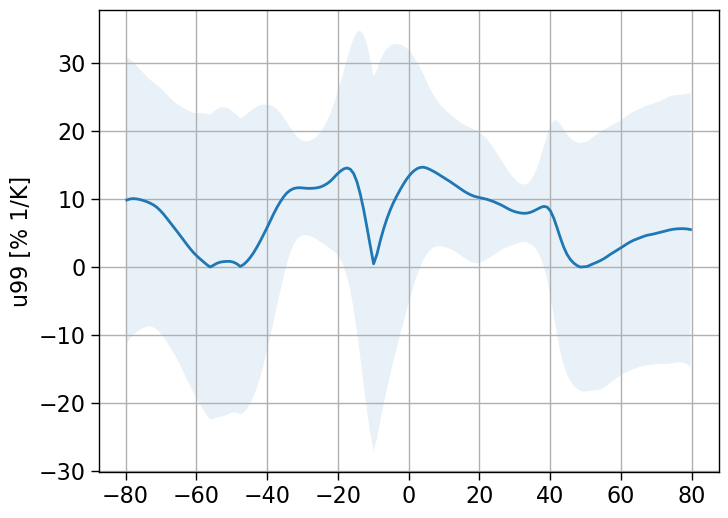

In [148]:
Ts = quantiles.TS.mean(['lat', 'lon']) # surface temperature [time]
u99 = quantiles.U200.sel(quantile=0.999, method='nearest')  # Datarray of U200 wind
u99_norm = (u99 - u99.min())/(u99.max() - u99.min())
def get_frac_change(winds, Ts):
    reg = scipy.stats.linregress(winds, Ts)
    return np.abs(reg.slope)  # Slope is oppposite in the two hemispheres

def get_std(winds, Ts):
    reg = scipy.stats.linregress(winds, Ts)
    return reg.stderr*np.sqrt(len(Ts))
    
frac_change = xr.apply_ufunc(
    get_frac_change,
    u99_norm,
    input_core_dims=[['time']], output_core_dims=[[]],
    kwargs={'Ts': Ts},
    dask = 'allowed', vectorize = True
)
frac_std = xr.apply_ufunc(
    get_std,
    u99_norm,
    input_core_dims=[['time']], output_core_dims=[[]],
    kwargs={'Ts': Ts},
    dask = 'allowed', vectorize = True
)
lats = frac_change.lat
plt.plot(lats, frac_change)
plt.fill_between(lats, frac_change-frac_std, frac_change+frac_std, alpha=0.1)

plt.ylabel('u99 [% 1/K]')
plt.grid(True)
plt.show()

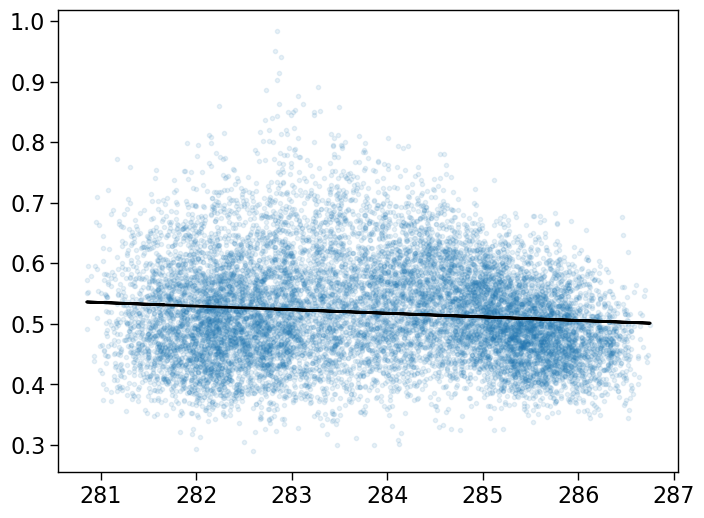

In [159]:
# Select one latitude for testing
lat_sel = u99_norm.sel(lat=45, method='nearest')#.isel(realization=0)
plt.scatter(Ts, lat_sel, alpha=0.1)
reg = scipy.stats.linregress(Ts, lat_sel)
plt.plot(Ts, reg.slope*Ts+reg.intercept, color='k')
# plt.plot(lat_sel)
# plt.plot(Ts_norm)
plt.show()

### Change in mean shear over time

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
years = NH['time.year'].values

NH_ref = NH.sel(time=slice('1978', '1990')).mean()
SH_ref = SH.sel(time=slice('1978', '1990')).mean()

NH_comp = (NH/NH_ref).mean(['lat', 'lon']).mean('realization')
SH_comp = (SH/SH_ref).mean(['lat', 'lon']).mean('realization')
# North hemisphere
ax.plot(years, NH_comp, label='N. Hemisphere')
ax.plot(years, SH_comp, label='S. Hemisphere')

# Compute piecewise linear fit
NH_pwlf = pwlf.PiecewiseLinFit(years, NH_comp)
breaks = NH_pwlf.fit(2)
break_year = int(breaks[1])
slopes = NH_pwlf.calc_slopes()*10*100 # percentage per decade
p_vals = NH_pwlf.p_values(method='non-linear')[1:]  # betas are [intercept, slope1, slope2, ...]
# print(f'Piecewise Parameters\n\tBreakpoint: {break_year}\n\tDecadal Slopes: {slopes}\n\tP-Values: {p_vals}')
y_hat = NH_pwlf.predict(years)
ax.plot(years, y_hat, color='red', linestyle='--', label=f'PWLF - {break_year} turning point')

# Make plot
# Add small annotation
ins = ax.inset_axes([0.15, 0.6, 0.25, 0.35])
pos = slopes > 0
neg = slopes < 0
l = np.array([1, 2])
for i, (m, p) in enumerate(zip(slopes, p_vals)):
    i+=1
    if m > 0:
        rects = ins.bar(i, m, color='red')
    else:
        rects = ins.bar(i, m, color='blue')
    if p < 0.01:
        ins.bar_label(rects, ['p$<$0.01'])
# Partition the percentile values to be able to draw large numbers in
# white within the bar, and small numbers in black outside the bar.
ins.hlines(0, 0.25, 2.75, color='k')
# Remove spines
ins.spines['top'].set_visible(False)
ins.spines['right'].set_visible(False)
ins.spines['bottom'].set_visible(False)
# Remove ticks
ins.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False,
)
# Set ticks
ymin = int(min(slopes))-1
ymax = int(max(slopes))+1
ins.set_yticks(np.arange(ymin, ymax, 0.25))
ins.tick_params(axis='y', labelsize=12)
ins.set_ylim(ymin, ymax)
ins.set_ylabel('Trend\n[% decade$^{-1}$]', fontsize=12)

ax.legend(loc='lower right', fontsize=14)
ax.set_ylabel('Thermal Wind\nFraction of 1978-1990 value')
ax.set_xlabel('Year')
ax.set_title('Thermal wind evolution')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10,6), layout='constrained')

years = NH['time.year'].values

for region, name, color in zip([NH, SH], ["N. Hemisphere", "S. Hemisphere"], ['red', 'black']):
    land = mask_data(region, land_region, ['land'], drop=np.nan)
    ocean = mask_data(region, land_region, ['land'], drop=np.nan, reverse=True)
    land_ts = land.mean(['lat', 'lon']).mean('realization')
    ocean_ts = ocean.mean(['lat', 'lon']).mean('realization')
    # Reference to 1978-1990 period
    land_ref = land_ts.sel(time=slice('1978', '1990')).mean().values
    ocean_ref = ocean_ts.sel(time=slice('1978', '1990')).mean().values
    ax.plot(years, (land_ts/land_ref)*100, label=f'Land - {name}', color=color)
    ax.plot(years, (ocean_ts/ocean_ref)*100, label=f'Ocean - {name}', color=color, linestyle=':')

ax.legend()
ax.set_ylabel('Thermal wind\n[% of 1978-1990 mean]')
ax.set_xlabel('Year')
ax.set_title('Extratropical Thermal Wind')

plt.show()

## Kill Dask Cluster

In [17]:
# client.shutdown()
# client.restart()